The final main colab can be accessed at https://colab.research.google.com/drive/1IU5ZWWouHFPTV29eOgz7BSQ_6fBYUvdD?usp=sharing.

The following codes are for the classifier model.

# Data Processing - Garbage Classifier

#### Efforts were made to merge 2 garbage datasets (1 with 12 classes, and 1 with 6 classes) together, forming pre-augmented dataset of 10 classes that will be used to train, validate, and test the Classifier model

In [ ]:
import torchvision.models
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%shell
COLAB_FOLDER="/content/drive/MyDrive/APS360 Group8"

cd "$COLAB_FOLDER"

find raw_dataset_nodups -type d -exec sh -c "find '{}' -maxdepth 1 -type f | wc -l; echo '\\b files: \t{}'" \; | tee files-michael.txt

0
 files: 	raw_dataset_nodups
869
 files: 	raw_dataset_nodups/plastic
985
 files: 	raw_dataset_nodups/biological
1050
 files: 	raw_dataset_nodups/paper
834
 files: 	raw_dataset_nodups/trash
945
 files: 	raw_dataset_nodups/battery
891
 files: 	raw_dataset_nodups/cardboard
1977
 files: 	raw_dataset_nodups/shoes
769
 files: 	raw_dataset_nodups/metal
5325
 files: 	raw_dataset_nodups/clothes
2044
 files: 	raw_dataset_nodups/glass


### Extract raw dataset

In [ ]:
%%shell
COLAB_FOLDER="/content/drive/MyDrive/APS360 Group8"

# List files in Colab folder and ensure it exists
ls "$COLAB_FOLDER"
if [[ "$?" != 0 ]]; then
    echo "'APS360 Group8' folder not found"
    echo "Please add 'APS360 Group8' as a shortcut to 'My Drive'"
    exit
fi

# Enter folder
cd "$COLAB_FOLDER"

# Purge old data
rm -rf /content/data

mkdir -p /content/data/12-classes
mkdir -p /content/data/6-classes

# Copy from Google Drive into Colab instance
cp 12-class-garbage-dataset.zip /content/data/12-classes/raw.zip
cp 6-class-garbage-dataset.zip /content/data/6-classes/raw.zip

# Extract data
cd /content/data
unzip /content/data/12-classes/raw.zip -d /content/data/12-classes/
unzip /content/data/6-classes/raw.zip -d /content/data/6-classes/

# Remove zip
rm /content/data/12-classes/raw.zip
rm /content/data/6-classes/raw.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/6-classes/Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: /content/data/6-classes/Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: /content/data/6-classes/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: /content/data/6-classes/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: /content/data/6-classes/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: /content/data/6-classes/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: /content/data/6-classes/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: /content/data/6-classes/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: /content/data/6-classes/Garbage classifi

In [ ]:
# Unmount Google Drive
drive.flush_and_unmount()

### Process data for duplicates

#### Remove exact duplicates

In [ ]:
%%shell
# Package to find duplicates
sudo apt install fdupes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fdupes is already the newest version (1:2.1.2-1build1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
%%shell
# Check number of files in each directory pre deduplication
find /content/data -type d -exec sh -c "find '{}' -maxdepth 1 -type f | wc -l; echo '\\b files: \t{}'" \; | tee files-count-pre-dedup.txt

# List all duplicates
fdupes /content/data -r --summarize | tee duplicates-summary.txt

# Execute deduplication
fdupes /content/data -rdN | tee duplicates.txt

# Remove empty subdirectories
find /content/data -type d -empty -delete

# Check number of files in each directory post deduplication
find /content/data -type d -exec sh -c "find '{}' -maxdepth 1 -type f | wc -l; echo '\\b files: \t{}'" \; | tee files-count-post-dedup.txt

Streaming output truncated to the last 5000 lines.


   [+] /content/data/6-classes/Garbage classification/Garbage classification/plastic/plastic28.jpg
   [-] /content/data/6-classes/garbage classification/Garbage classification/plastic/plastic28.jpg
   [-] /content/data/12-classes/garbage_classification/plastic/plastic87.jpg


   [+] /content/data/6-classes/Garbage classification/Garbage classification/plastic/plastic303.jpg
   [-] /content/data/6-classes/garbage classification/Garbage classification/plastic/plastic303.jpg
   [-] /content/data/12-classes/garbage_classification/plastic/plastic120.jpg


   [+] /content/data/6-classes/Garbage classification/Garbage classification/plastic/plastic307.jpg
   [-] /content/data/6-classes/garbage classification/Garbage classification/plastic/plastic307.jpg
   [-] /content/data/12-classes/garbage_classification/plastic/plastic125.jpg


   [+] /content/data/6-classes/Garbage classification/Garbage classification/plastic/plastic72.jpg
   [-] /con

In [ ]:
%%shell
# Move files to a directory without spaces (which will break the commands
# that follow)
mv /content/data/6-classes/Garbage\ classification/Garbage\ classification/ /content/data/6-classes/garbage_classification


# Remove empty subdirectories
find /content/data -type d -empty -delete

In [ ]:
%%shell
# Remove text files that cause problems for next stage
find /content/data/ -type f -name "*.txt" -delete

#### Remove near duplicates

In [ ]:
%%shell
sudo apt install findimagedupes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  libencode-locale-perl libfile-basedir-perl libfile-desktopentry-perl
  libfile-mimeinfo-perl libgraphics-magick-perl libgraphicsmagick-q16-3 libgs9
  libgs9-common libgtkd-3-0 libidn12 libijs-0.35 libinline-c-perl
  libinline-files-perl libinline-perl libio-stringy-perl
  libipc-system-simple-perl libjbig2dec0 libllvm11 libparse-recdescent-perl
  libpegex-perl libphobos2-ldc-shared98 libtie-ixhash-perl liburi-perl
  libvte-2.91-0 libvte-2.91-common libvted-3-0 libwmflite-0.2-7 libxxx-perl
  libyaml-pp-perl poppler-data tilix tilix-common
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x graphicsmagick-dbg libbusiness-isbn-perl libwww-perl
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-jap

In [ ]:
%%shell
# Find visually similar images

# We must send error stream to /dev/null to avoid errors from
# polluting the file duplicate list as it seems like
# findimagedupes was not properly packaged
findimagedupes --recurse /content/data --threshold 0b 2> /dev/null | tee files-similar-images.txt

/content/data/12-classes/garbage_classification/biological/biological295.jpg /content/data/12-classes/garbage_classification/biological/biological307.jpg
/content/data/12-classes/garbage_classification/shoes/shoes296.jpg /content/data/12-classes/garbage_classification/shoes/shoes301.jpg
/content/data/12-classes/garbage_classification/shoes/shoes298.jpg /content/data/12-classes/garbage_classification/shoes/shoes1172.jpg
/content/data/12-classes/garbage_classification/metal/metal552.jpg /content/data/12-classes/garbage_classification/battery/battery65.jpg
/content/data/12-classes/garbage_classification/green-glass/green-glass606.jpg /content/data/12-classes/garbage_classification/brown-glass/brown-glass373.jpg
/content/data/12-classes/garbage_classification/battery/battery35.jpg /content/data/12-classes/garbage_classification/battery/battery129.jpg
/content/data/12-classes/garbage_classification/clothes/clothes3497.jpg /content/data/12-classes/garbage_classification/clothes/clothes4104.j

In [ ]:
import matplotlib.pyplot as plt
import PIL
import numpy as np

2 ['/content/data/12-classes/garbage_classification/biological/biological295.jpg', '/content/data/12-classes/garbage_classification/biological/biological307.jpg']
2 ['/content/data/12-classes/garbage_classification/shoes/shoes296.jpg', '/content/data/12-classes/garbage_classification/shoes/shoes301.jpg']
2 ['/content/data/12-classes/garbage_classification/shoes/shoes298.jpg', '/content/data/12-classes/garbage_classification/shoes/shoes1172.jpg']
2 ['/content/data/12-classes/garbage_classification/metal/metal552.jpg', '/content/data/12-classes/garbage_classification/battery/battery65.jpg']
2 ['/content/data/12-classes/garbage_classification/green-glass/green-glass606.jpg', '/content/data/12-classes/garbage_classification/brown-glass/brown-glass373.jpg']
2 ['/content/data/12-classes/garbage_classification/battery/battery35.jpg', '/content/data/12-classes/garbage_classification/battery/battery129.jpg']
2 ['/content/data/12-classes/garbage_classification/clothes/clothes3497.jpg', '/content

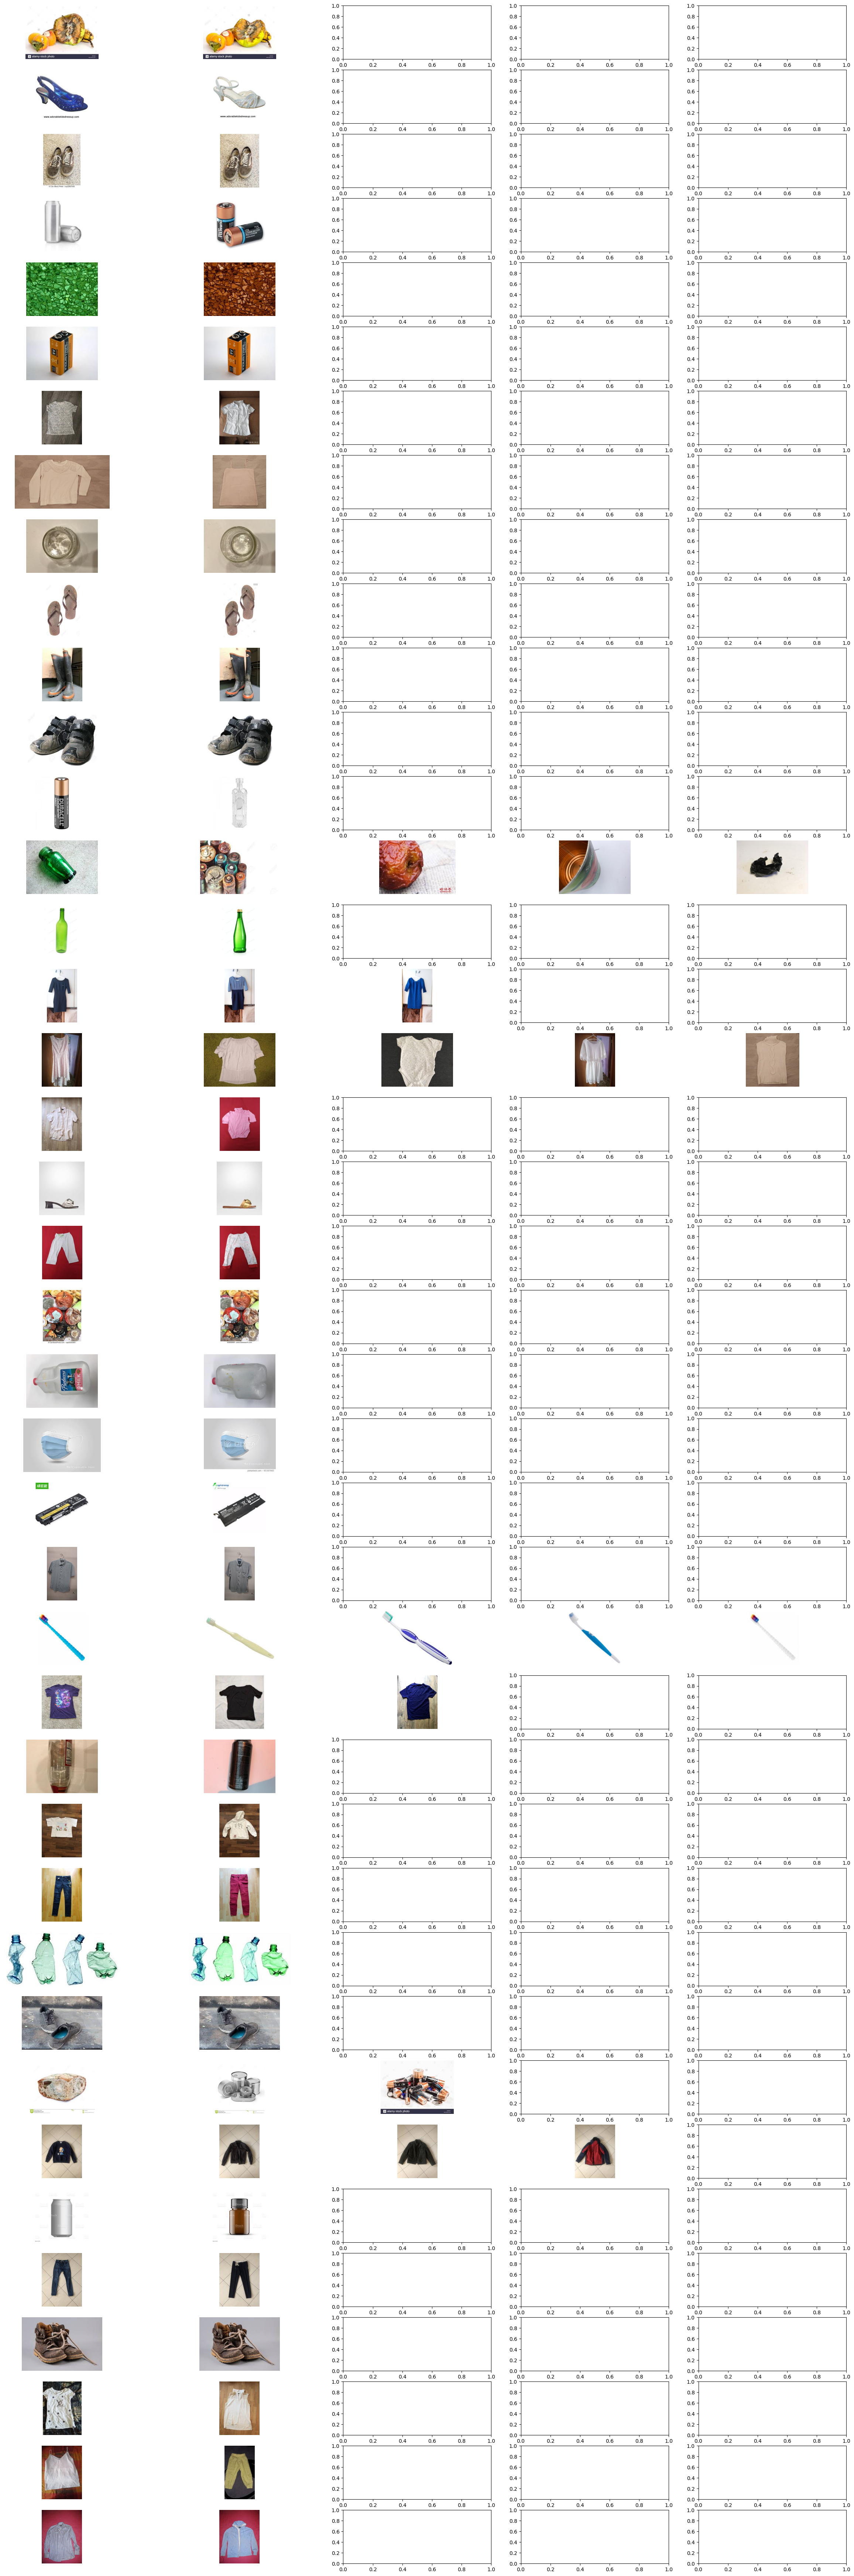

In [ ]:
# Parse out visually similar images list
duplicates = []
max_similar_group_size = 0
with open("files-similar-images.txt") as f:
    for line in f:
        duplicate = line.strip().split(" ")
        duplicates.append(duplicate)
        print(len(duplicate), duplicate)
        max_similar_group_size = max(len(duplicate), max_similar_group_size)

print("Image with the most matches: ", max_similar_group_size)
print("Number of unique images: ", len(duplicates))

# Print out list of similar images so we can verify
# the detected images are not false positives
show_first_n_img = 40
show_first_n_of_duplicate = 5
k = 0
fig, axes = plt.subplots(show_first_n_img, show_first_n_of_duplicate, figsize=(30, 90))
for duplicate in duplicates:
    # Only show first n images to prevent flooding Colab
    if (k >= show_first_n_img):
        break

    j = 0
    for img in duplicate:
        if (j >= show_first_n_of_duplicate):
            break
        axes[k, j].imshow(np.array(PIL.Image.open(img)))
        axes[k, j].axis('off')
        j += 1

    k += 1

plt.show()

#### Re-organize files into desired classes

In [ ]:
%%shell

# ('paper','glass', 'trash', 'metal','plastic','battery','biological', 'clothes','shoes','cardboard')

mkdir -p /content/data/clean/paper
mkdir -p /content/data/clean/glass
mkdir -p /content/data/clean/trash
mkdir -p /content/data/clean/metal
mkdir -p /content/data/clean/plastic
mkdir -p /content/data/clean/battery
mkdir -p /content/data/clean/biological
mkdir -p /content/data/clean/clothes
mkdir -p /content/data/clean/shoes
mkdir -p /content/data/clean/cardboard

# Move 12-classes garbage dataset to correct classes
# backup=t just renames if file already exists
cp -r --backup=t /content/data/12-classes/garbage_classification/brown-glass/* /content/data/clean/glass
cp -r --backup=t /content/data/12-classes/garbage_classification/green-glass/* /content/data/clean/glass
cp -r --backup=t /content/data/12-classes/garbage_classification/white-glass/* /content/data/clean/glass
cp -r --backup=t /content/data/12-classes/garbage_classification/cardboard/* /content/data/clean/cardboard
cp -r --backup=t /content/data/12-classes/garbage_classification/paper/* /content/data/clean/paper
cp -r --backup=t /content/data/12-classes/garbage_classification/metal/* /content/data/clean/metal
cp -r --backup=t /content/data/12-classes/garbage_classification/plastic/* /content/data/clean/plastic
cp -r --backup=t /content/data/12-classes/garbage_classification/trash/* /content/data/clean/trash
cp -r --backup=t /content/data/12-classes/garbage_classification/battery/* /content/data/clean/battery
cp -r --backup=t /content/data/12-classes/garbage_classification/biological/* /content/data/clean/biological
cp -r --backup=t /content/data/12-classes/garbage_classification/clothes/* /content/data/clean/clothes
cp -r --backup=t /content/data/12-classes/garbage_classification/shoes/* /content/data/clean/shoes



# Move 6-classes garbage dataset to correct classes
cp -r --backup=t /content/data/6-classes/garbage_classification/glass/* /content/data/clean/glass
cp -r --backup=t /content/data/6-classes/garbage_classification/cardboard/* /content/data/clean/cardboard
cp -r --backup=t /content/data/6-classes/garbage_classification/paper/* /content/data/clean/paper
cp -r --backup=t /content/data/6-classes/garbage_classification/metal/* /content/data/clean/metal
cp -r --backup=t /content/data/6-classes/garbage_classification/plastic/* /content/data/clean/plastic
cp -r --backup=t /content/data/6-classes/garbage_classification/trash/* /content/data/clean/trash

# Remove the original dataset
rm -rf /content/data/12-classes/
rm -rf /content/data/6-classes/


In [ ]:
%%shell
# Check number of files in each directory after cleaning
find /content/data/clean -type d -exec sh -c "find '{}' -maxdepth 1 -type f | wc -l; echo '\\b files: \t{}'" \; | tee files-pre-crop.txt

0
 files: 	/content/data/clean
1050
 files: 	/content/data/clean/paper
834
 files: 	/content/data/clean/trash
867
 files: 	/content/data/clean/plastic
1977
 files: 	/content/data/clean/shoes
2024
 files: 	/content/data/clean/glass
768
 files: 	/content/data/clean/metal
891
 files: 	/content/data/clean/cardboard
945
 files: 	/content/data/clean/battery
985
 files: 	/content/data/clean/biological
5324
 files: 	/content/data/clean/clothes


In [ ]:
%%shell

zip clean-no-crop.zip -r /content/data/clean

Streaming output truncated to the last 5000 lines.
  adding: content/data/clean/clothes/clothes4566.jpg (deflated 0%)
  adding: content/data/clean/clothes/clothes1385.jpg (deflated 0%)
  adding: content/data/clean/clothes/clothes4911.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes4394.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes3074.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes5060.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes4636.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes3593.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes5303.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes85.jpg (deflated 0%)
  adding: content/data/clean/clothes/clothes3555.jpg (deflated 2%)
  adding: content/data/clean/clothes/clothes5248.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes3862.jpg (deflated 1%)
  adding: content/data/clean/clothes/clothes2872.jpg (deflated 0%)
  adding: con

#### Crop images to 224x224 (deprecated)

In [ ]:
%%shell
sudo apt install imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
imagemagick is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.3).
imagemagick set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
!cat /etc/ImageMagick-6/policy.xml

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE policymap [
  <!ELEMENT policymap (policy)*>
  <!ATTLIST policymap xmlns CDATA #FIXED ''>
  <!ELEMENT policy EMPTY>
  <!ATTLIST policy xmlns CDATA #FIXED '' domain NMTOKEN #REQUIRED
    name NMTOKEN #IMPLIED pattern CDATA #IMPLIED rights NMTOKEN #IMPLIED
    stealth NMTOKEN #IMPLIED value CDATA #IMPLIED>
]>
<!--
  Configure ImageMagick policies.

  Domains include system, delegate, coder, filter, path, or resource.

  Rights include none, read, write, execute and all.  Use | to combine them,
  for example: "read | write" to permit read from, or write to, a path.

  Use a glob expression as a pattern.

  Suppose we do not want users to process MPEG video images:

    <policy domain="delegate" rights="none" pattern="mpeg:decode" />

  Here we do not want users reading images from HTTP:

    <policy domain="coder" rights="none" pattern="HTTP" />

  The /repository file system is restricted to read only.  We use a glob
  expression to match 

In [ ]:
%%shell
# need to increase size of image magick policy since not enough ram
cp policy.xml /etc/ImageMagick-6/policy.xml

cp: cannot stat 'policy.xml': No such file or directory


CalledProcessError: ignored

In [ ]:
%%shell
# Crop each image into 224x224
cd /content/data/clean

cd glass
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

cd ../metal
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

cd ../paper
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

cd ../plastic
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

cd ../trash
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;



cd ../cardboard
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

cd ../battery
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

cd ../biological
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

cd ../clothes
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

cd ../shoes
find *.jpg -type f -exec sh -c "convert {} -resize 224x224^ -gravity Center -crop 224x224+0+0 +repage clean-{}" \;

In [ ]:
%%shell
cd /content/data/clean
find -type f -name "*.jpg" | grep -v "clean" | sed -e 's/^/rm /' | tee rm-files-dirty.sh
chmod a+x rm-files-dirty.sh
./rm-files-dirty.sh
rm rm-files-dirty.sh

Streaming output truncated to the last 5000 lines.
rm ./clothes/clothes1293.jpg
rm ./clothes/clothes1294.jpg
rm ./clothes/clothes1295.jpg
rm ./clothes/clothes1296.jpg
rm ./clothes/clothes1297.jpg
rm ./clothes/clothes1298.jpg
rm ./clothes/clothes1299.jpg
rm ./clothes/clothes129.jpg
rm ./clothes/clothes12.jpg
rm ./clothes/clothes1300.jpg
rm ./clothes/clothes1301.jpg
rm ./clothes/clothes1302.jpg
rm ./clothes/clothes1303.jpg
rm ./clothes/clothes1304.jpg
rm ./clothes/clothes1305.jpg
rm ./clothes/clothes1306.jpg
rm ./clothes/clothes1307.jpg
rm ./clothes/clothes1308.jpg
rm ./clothes/clothes1309.jpg
rm ./clothes/clothes130.jpg
rm ./clothes/clothes1310.jpg
rm ./clothes/clothes1311.jpg
rm ./clothes/clothes1312.jpg
rm ./clothes/clothes1313.jpg
rm ./clothes/clothes1314.jpg
rm ./clothes/clothes1315.jpg
rm ./clothes/clothes1316.jpg
rm ./clothes/clothes1317.jpg
rm ./clothes/clothes1318.jpg
rm ./clothes/clothes1319.jpg
rm ./clothes/clothes131.jpg
rm ./clothes/clothes1320.jpg
rm ./clothes/clothes1321.j

In [ ]:
%%shell
# Check number of files in each directory after cleaning
find /content/data/clean -type d -exec sh -c "find '{}' -maxdepth 1 -type f | wc -l; echo '\\b files: \t{}'" \; | tee files-count-clean.txt

0
 files: 	/content/data/clean
1050
 files: 	/content/data/clean/paper
834
 files: 	/content/data/clean/trash
867
 files: 	/content/data/clean/plastic
1977
 files: 	/content/data/clean/shoes
2024
 files: 	/content/data/clean/glass
768
 files: 	/content/data/clean/metal
891
 files: 	/content/data/clean/cardboard
945
 files: 	/content/data/clean/battery
985
 files: 	/content/data/clean/biological
5324
 files: 	/content/data/clean/clothes


In [ ]:
%%shell
# Check aspect ratio of images to ensure proper crop
find /content/data/clean -type f -exec sh -c 'identify -format "%[fx:w]x%[fx:h], %M\n" {}' \; | tee files-image-crop-qc.txt

Streaming output truncated to the last 5000 lines.
224x224, /content/data/clean/clothes/clean-clothes386.jpg
224x224, /content/data/clean/clothes/clean-clothes1201.jpg
224x224, /content/data/clean/clothes/clean-clothes4553.jpg
224x224, /content/data/clean/clothes/clean-clothes2451.jpg
224x224, /content/data/clean/clothes/clean-clothes4941.jpg
224x224, /content/data/clean/clothes/clean-clothes974.jpg
224x224, /content/data/clean/clothes/clean-clothes416.jpg
224x224, /content/data/clean/clothes/clean-clothes4555.jpg
224x224, /content/data/clean/clothes/clean-clothes154.jpg
224x224, /content/data/clean/clothes/clean-clothes1980.jpg
224x224, /content/data/clean/clothes/clean-clothes3500.jpg
224x224, /content/data/clean/clothes/clean-clothes228.jpg
224x224, /content/data/clean/clothes/clean-clothes3473.jpg
224x224, /content/data/clean/clothes/clean-clothes1492.jpg
224x224, /content/data/clean/clothes/clean-clothes332.jpg
224x224, /content/data/clean/clothes/clean-clothes3785.jpg
224x224, /c

In [ ]:
# Parse out image crop list
images = []
with open("files-image-crop-qc.txt") as f:
    for line in f:
        image = line.strip().split(", ")
        images.append(image)

failed = 0
success = 0
delete_queue = []
with open("files-image-crop-delete.sh", 'w') as f:
    for image in images:
        if image[0] != "224x224":
            failed += 1
            delete_queue.append(image[1])
            f.write("rm " + image[1] + "\n")
        else:
            success += 1

print(failed, " images failed qc")
print(success, " images passed qc")

735  images failed qc
14930  images passed qc


In [ ]:
%%shell
chmod a+x files-image-crop-delete.sh
./files-image-crop-delete.sh

In [ ]:
%%shell
# Check number of files in each directory after cleaning
find /content/data/clean -type d -exec sh -c "find '{}' -maxdepth 1 -type f | wc -l; echo '\\b files: \t{}'" \; | tee files-count-clean.txt

0
 files: 	/content/data/clean
0
 files: 	/content/data/clean/train
550
 files: 	/content/data/clean/train/paper
550
 files: 	/content/data/clean/train/plastic
550
 files: 	/content/data/clean/train/trash
550
 files: 	/content/data/clean/train/metal
550
 files: 	/content/data/clean/train/glass
0
 files: 	/content/data/clean/test
65
 files: 	/content/data/clean/test/paper
65
 files: 	/content/data/clean/test/plastic
65
 files: 	/content/data/clean/test/trash
65
 files: 	/content/data/clean/test/metal
65
 files: 	/content/data/clean/test/glass
0
 files: 	/content/data/clean/val
65
 files: 	/content/data/clean/val/paper
65
 files: 	/content/data/clean/val/plastic
65
 files: 	/content/data/clean/val/trash
65
 files: 	/content/data/clean/val/metal
65
 files: 	/content/data/clean/val/glass


In [ ]:
%%shell
rm clean.zip
zip clean.zip -r /content/data/clean

Streaming output truncated to the last 5000 lines.
  adding: content/data/clean/paper/clean-cardboard278.jpg (deflated 1%)
  adding: content/data/clean/paper/clean-cardboard525.jpg (deflated 4%)
  adding: content/data/clean/paper/clean-cardboard769.jpg (deflated 1%)
  adding: content/data/clean/paper/clean-cardboard486.jpg (deflated 2%)
  adding: content/data/clean/paper/clean-cardboard427.jpg (deflated 1%)
  adding: content/data/clean/paper/clean-paper224.jpg (deflated 0%)
  adding: content/data/clean/paper/clean-paper226.jpg (deflated 1%)
  adding: content/data/clean/paper/clean-paper453.jpg (deflated 1%)
  adding: content/data/clean/paper/clean-cardboard362.jpg (deflated 1%)
  adding: content/data/clean/paper/clean-cardboard673.jpg (deflated 0%)
  adding: content/data/clean/paper/clean-paper408.jpg (deflated 0%)
  adding: content/data/clean/paper/clean-cardboard606.jpg (deflated 1%)
  adding: content/data/clean/paper/clean-cardboard833.jpg (deflated 1%)
  adding: content/data/clean/

#### Train/Validation/Test Split (deprecated)

In [ ]:
%%shell
# Get all files in dataset so we can annotate it
find /content/data/clean/ -type f | tee dataset-annotation.txt

Streaming output truncated to the last 5000 lines.
/content/data/clean/paper/clean-cardboard242.jpg
/content/data/clean/paper/clean-paper31.jpg
/content/data/clean/paper/clean-cardboard658.jpg
/content/data/clean/paper/clean-cardboard827.jpg
/content/data/clean/paper/clean-cardboard278.jpg
/content/data/clean/paper/clean-cardboard525.jpg
/content/data/clean/paper/clean-cardboard769.jpg
/content/data/clean/paper/clean-cardboard486.jpg
/content/data/clean/paper/clean-cardboard427.jpg
/content/data/clean/paper/clean-paper224.jpg
/content/data/clean/paper/clean-paper226.jpg
/content/data/clean/paper/clean-paper453.jpg
/content/data/clean/paper/clean-cardboard362.jpg
/content/data/clean/paper/clean-cardboard673.jpg
/content/data/clean/paper/clean-paper408.jpg
/content/data/clean/paper/clean-cardboard606.jpg
/content/data/clean/paper/clean-cardboard833.jpg
/content/data/clean/paper/clean-paper774.jpg
/content/data/clean/paper/clean-cardboard291.jpg
/content/data/clean/paper/clean-cardboard26

In [ ]:
directory_prefix = "/content/data/clean/"
data_split = {}
wasted = 0

with open("dataset-annotation.txt") as f:
    for line in f:
        image_path = line.rstrip().split("/")
        image_class = image_path[4]
        image_name = f"{image_path[4]}/{image_path[5]}"

        # Create dictionary/list if it does not exist
        if image_class not in data_split:
            data_split[image_class] = {}
        if "test" not in data_split[image_class]:
            data_split[image_class]["test"] = []
        if "val" not in data_split[image_class]:
            data_split[image_class]["val"] = []
        if "train" not in data_split[image_class]:
            data_split[image_class]["train"] = []

        # First 20 goes to test, Next 20 goes to validation
        # Remaining 160 goes to training set
        # All others are ignored
        if len(data_split[image_class]["test"]) < 65:
            data_split[image_class]["test"].append(image_name)
        elif len(data_split[image_class]["val"]) < 65:
            data_split[image_class]["val"].append(image_name)
        elif len(data_split[image_class]["train"]) < 550:
            data_split[image_class]["train"].append(image_name)
        else:
            wasted += 1

with open("dataset-split.sh", "w") as f:
    # Construct bash script to create the needed directories
    for image_class in ('paper','glass', 'trash', 'metal','plastic','battery','biological', 'clothes','shoes','cardboard'):
        f.write(f"mkdir -p {directory_prefix}test/{image_class}\n")
        f.write(f"mkdir -p {directory_prefix}val/{image_class}\n")
        f.write(f"mkdir -p {directory_prefix}train/{image_class}\n")

    # Construct bash script to move files to corresponding test/val/train folder
    for image_class in data_split:
        image_group = data_split[image_class]
        for image_name in image_group["test"]:
            f.write(f"mv {directory_prefix}{image_name} {directory_prefix}test/{image_name}\n")
        for image_name in image_group["val"]:
            f.write(f"mv {directory_prefix}{image_name} {directory_prefix}val/{image_name}\n")
        for image_name in image_group["train"]:
            f.write(f"mv {directory_prefix}{image_name} {directory_prefix}train/{image_name}\n")

In [ ]:
%%shell
chmod a+x dataset-split.sh
./dataset-split.sh

In [ ]:
%%shell
# Check number of files in each directory
find /content/data -type d -exec sh -c "find '{}' -maxdepth 1 -type f | wc -l; echo '\\b files: \t{}'" \;

0
 files: 	/content/data
0
 files: 	/content/data/clean
792
 files: 	/content/data/clean/paper
102
 files: 	/content/data/clean/plastic
17
 files: 	/content/data/clean/trash
0
 files: 	/content/data/clean/train
550
 files: 	/content/data/clean/train/paper
550
 files: 	/content/data/clean/train/plastic
550
 files: 	/content/data/clean/train/trash
550
 files: 	/content/data/clean/train/metal
550
 files: 	/content/data/clean/train/glass
0
 files: 	/content/data/clean/test
65
 files: 	/content/data/clean/test/paper
65
 files: 	/content/data/clean/test/plastic
65
 files: 	/content/data/clean/test/trash
65
 files: 	/content/data/clean/test/metal
65
 files: 	/content/data/clean/test/glass
38
 files: 	/content/data/clean/metal
1343
 files: 	/content/data/clean/glass
0
 files: 	/content/data/clean/val
65
 files: 	/content/data/clean/val/paper
65
 files: 	/content/data/clean/val/plastic
65
 files: 	/content/data/clean/val/trash
65
 files: 	/content/data/clean/val/metal
65

In [ ]:
%%shell
rm -rf /content/data/clean/glass
rm -rf /content/data/clean/metal
rm -rf /content/data/clean/paper
rm -rf /content/data/clean/plastic
rm -rf /content/data/clean/trash

In [ ]:
%%shell
zip clean-split.zip -r /content/data/clean

  adding: content/data/clean/ (stored 0%)
  adding: content/data/clean/train/ (stored 0%)
  adding: content/data/clean/train/paper/ (stored 0%)
  adding: content/data/clean/train/paper/clean-cardboard248.jpg (deflated 1%)
  adding: content/data/clean/train/paper/clean-paper190.jpg (deflated 1%)
  adding: content/data/clean/train/paper/clean-paper529.jpg (deflated 1%)
  adding: content/data/clean/train/paper/clean-cardboard680.jpg (deflated 4%)
  adding: content/data/clean/train/paper/clean-paper470.jpg (deflated 0%)
  adding: content/data/clean/train/paper/clean-cardboard881.jpg (deflated 1%)
  adding: content/data/clean/train/paper/clean-paper516.jpg (deflated 1%)
  adding: content/data/clean/train/paper/clean-paper377.jpg (deflated 1%)
  adding: content/data/clean/train/paper/clean-cardboard168.jpg (deflated 3%)
  adding: content/data/clean/train/paper/clean-paper215.jpg (deflated 0%)
  adding: content/data/clean/train/paper/clean-paper42.jpg (deflated 0%)
  adding: content/data/clea